In [1]:
# CUDA environment setup and validation
import os
import subprocess

def setup_cuda_environment():
    """Setup and validate CUDA environment"""
    
    # Clear any conflicting environment variables
    if 'CUDA_VISIBLE_DEVICES' in os.environ:
        del os.environ['CUDA_VISIBLE_DEVICES']
    
    # Set CUDA environment variables
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    os.environ['TORCH_USE_CUDA_DSA'] = '1'
    
    # Check CUDA availability
    print("=== CUDA Environment Check ===")
    print(f"CUDA_HOME: {os.environ.get('CUDA_HOME', 'Not set')}")
    print(f"LD_LIBRARY_PATH: {os.environ.get('LD_LIBRARY_PATH', 'Not set')}")
    
    # Check PyTorch CUDA
    import torch
    print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA version: {torch.version.cuda}")
        print(f"Number of GPUs: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    
    # Check system CUDA
    try:
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader,nounits'], 
                              capture_output=True, text=True)
        if result.returncode == 0:
            print("System GPU check:")
            for line in result.stdout.strip().split('\n'):
                if line:
                    name, memory = line.split(', ')
                    print(f"  {name}: {memory} MB")
    except Exception as e:
        print(f"Could not check system GPU: {e}")

# Run this setup
setup_cuda_environment()

=== CUDA Environment Check ===
CUDA_HOME: /usr/local/cuda-12.4
LD_LIBRARY_PATH: /usr/local/cuda-12.4/lib64:/tmp/.mount_cursorSrhAKu/usr/lib/:/tmp/.mount_cursorSrhAKu/usr/lib32/:/tmp/.mount_cursorSrhAKu/usr/lib64/:/tmp/.mount_cursorSrhAKu/lib/:/tmp/.mount_cursorSrhAKu/lib/i386-linux-gnu/:/tmp/.mount_cursorSrhAKu/lib/x86_64-linux-gnu/:/tmp/.mount_cursorSrhAKu/lib/aarch64-linux-gnu/:/tmp/.mount_cursorSrhAKu/lib32/:/tmp/.mount_cursorSrhAKu/lib64/:
PyTorch CUDA available: True
CUDA version: 12.4
Number of GPUs: 1
GPU 0: NVIDIA RTX A6000
System GPU check:
  NVIDIA RTX A6000: 49140 MB


In [2]:
# Check PyTorch CUDA version compatibility
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch CUDA version: {torch.version.cuda}")
print(f"System CUDA version: 12.4")
print(f"CUDA_HOME: {os.environ.get('CUDA_HOME')}")

# Check if there's a version mismatch
if torch.version.cuda != "12.4":
    print(f"⚠️  VERSION MISMATCH: PyTorch expects CUDA {torch.version.cuda}, but system has CUDA 12.4")

PyTorch version: 2.6.0+cu124
PyTorch CUDA version: 12.4
System CUDA version: 12.4
CUDA_HOME: /usr/local/cuda-12.4


In [3]:
# MONAI Dual-Task (Segmentation + Classification) training using nnU-Net-style pipeline
# - Dataset: derived/unified_dualtask (train/val/test CSVs)
# - Spacing standardization to (0.8, 0.8, 1.0) mm
# - Label-preserving resample via one-hot + optional dilate-then-erode
# - Sliding-window patch training (192x192x160)
# - Shared-encoder segmentation (DynUNet) + classification head
# - QC counters that flag label shrinkage post-resample

import os
import math
import time
import json
import random
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast, GradScaler

import nibabel as nib

from monai.config import print_config
from monai.data import CacheDataset, DataLoader, decollate_batch
from monai.data.utils import no_collation
from monai.inferers import SlidingWindowInferer
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.networks.nets import DynUNet
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    EnsureTyped,
    Orientationd,
    Spacingd,
    ScaleIntensityRanged,
    RandSpatialCropd,
    RandFlipd,
    RandRotate90d,
    RandAffined,
    AsDiscreted,
    EnsureTyped,
    CastToTyped,
)
from monai.utils import set_determinism

print_config()


MONAI version: 1.5.0+11.gcafc1feb
Numpy version: 2.3.2
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: cafc1feb5063ccbc206a71d2f006b3ea386a74b4
MONAI __file__: /home/<username>/projects/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.4
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.16.1
Pillow version: 11.3.0
Tensorboard version: 2.20.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: 1.7.3
psutil version: 7.0.0
pandas version: 2.3.1
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 3.3.0
pynrrd version: 1.1.3
clearml version: 2.0.3rc0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [5]:
# Reproducibility
SEED = 42
set_determinism(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Paths
PROJ_ROOT = Path('/home/qarc/projects/DHAI-Brain-Segmentation')
DUALTASK_ROOT = PROJ_ROOT / 'derived' / 'unified_dualtask'
TRAIN_CSV = DUALTASK_ROOT / 'train_fixed.csv'
VAL_CSV = DUALTASK_ROOT / 'val_fixed.csv'
TEST_CSV = DUALTASK_ROOT / 'test_fixed.csv'

assert TRAIN_CSV.exists() and VAL_CSV.exists() and TEST_CSV.exists(), 'Split CSVs missing'

# Target spacing and patch params
TARGET_SPACING = (0.8, 0.8, 1.0)
PATCH_SIZE = (192, 192, 160)
PATCH_OVERLAP = 0.5  # sliding window overlap


Device: cuda


In [6]:
# CSV -> dict list helpers

def read_unified_csv(path: Path) -> List[Dict]:
    df = pd.read_csv(path)
    # expected columns: case_id,class_label,image_path,label_path
    items = []
    for _, row in df.iterrows():
        items.append({
            'case_id': row['case_id'],
            'image': row['image_path'],
            'label': row['label_path'],
            'class_label': int(row['class_label']),
        })
    return items

train_items = read_unified_csv(TRAIN_CSV)
val_items = read_unified_csv(VAL_CSV)
test_items = read_unified_csv(TEST_CSV)

len(train_items), len(val_items), len(test_items)


(972, 209, 207)

In [7]:
# Morphology utilities and QC counters
import scipy.ndimage as ndi

class LabelQC:
    def __init__(self, shrink_warn_threshold: float = 0.35):
        self.shrink_warn_threshold = shrink_warn_threshold
        self.total = 0
        self.warn = 0
    def update(self, before_voxels: int, after_voxels: int, case_id: str):
        self.total += 1
        if before_voxels > 0:
            ratio = (after_voxels + 1e-6) / (before_voxels + 1e-6)
            if ratio < (1.0 - self.shrink_warn_threshold):
                self.warn += 1
                print(f'[QC] label shrinkage: {case_id} before={before_voxels} after={after_voxels} ratio={ratio:.3f}')
    def summary(self):
        print(f'[QC] shrinkage warnings: {self.warn}/{self.total}')


def binary_dilate_then_erode(mask: np.ndarray, radius_vox: int = 1) -> np.ndarray:
    if radius_vox <= 0:
        return mask
    structure = ndi.generate_binary_structure(3, 1)
    for _ in range(radius_vox):
        mask = ndi.binary_dilation(mask, structure=structure)
    for _ in range(radius_vox):
        mask = ndi.binary_erosion(mask, structure=structure)
    return mask


In [8]:
# Transforms: spacing standardization and intensity scale
# Labels are handled with a custom post-transform step to preserve small lesions via one-hot resample and optional morph.

from monai.transforms import MapTransform

class OneHotResampleWithMorphology(MapTransform):
    def __init__(self, keys, num_classes: int = 2, morph_radius: int = 0, allow_missing_keys: bool = False):
        super().__init__(keys, allow_missing_keys)
        self.num_classes = num_classes
        self.morph_radius = morph_radius

    def __call__(self, data):
        d = dict(data)
        # expects d['label'] to be a MONAI image tensor with metadata spacing attached
        label = d['label']  # torch.Tensor [1, D, H, W] after EnsureChannelFirstd
        meta = d.get('label_meta_dict', {})
        # Before voxels for QC
        before_vox = int((label > 0.5).sum().item())

        # one-hot
        label_oh = F.one_hot(label.long().squeeze(0), num_classes=self.num_classes).permute(3, 0, 1, 2).float()

        # resample using metadata of image (already resampled) to match size via trilinear/nearest
        # assume image and label now share the same shape; if not, interpolate to image shape
        img = d['image']
        if label_oh.shape[1:] != img.shape[1:]:
            # channels first
            label_oh = F.interpolate(label_oh.unsqueeze(0), size=img.shape[1:], mode='trilinear', align_corners=False).squeeze(0)
        # discretize back to argmax
        label_res = label_oh.argmax(dim=0, keepdim=True)

        # optional light morph
        if self.morph_radius > 0:
            arr = label_res.detach().cpu().numpy().astype(np.uint8)
            arr = binary_dilate_then_erode(arr[0], radius_vox=self.morph_radius)[None]
            label_res = torch.as_tensor(arr, dtype=torch.long, device=label_res.device)

        after_vox = int((label_res > 0).sum().item())
        d['label'] = label_res
        d['qc_before_vox'] = before_vox
        d['qc_after_vox'] = after_vox
        return d

TARGET_MODE = 'bilinear'

common_load = [
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    EnsureTyped(keys=['image', 'label'], dtype=torch.float32),
    Orientationd(keys=['image', 'label'], axcodes='RAS'),
    Spacingd(keys=['image', 'label'], pixdim=TARGET_SPACING, mode=('bilinear', 'nearest')),
]

from monai.transforms import RandCropByPosNegLabeld, SpatialPadd

intensity_train = [
    ScaleIntensityRanged(keys=['image'], a_min=0, a_max=3000, b_min=0.0, b_max=1.0, clip=True),
    RandFlipd(keys=['image', 'label'], spatial_axis=[0, 1, 2], prob=0.2),
    RandRotate90d(keys=['image', 'label'], prob=0.2, max_k=3),
    RandAffined(keys=['image', 'label'], rotate_range=(math.pi/36, math.pi/36, math.pi/36),
                scale_range=(0.1, 0.1, 0.1), mode=('bilinear', 'nearest'), prob=0.2),
    SpatialPadd(keys=['image', 'label'], spatial_size=PATCH_SIZE),
    RandCropByPosNegLabeld(keys=['image', 'label'], label_key='label', spatial_size=PATCH_SIZE,
                           pos=1, neg=1, num_samples=1, image_key='image', allow_smaller=True),
]

intensity_val = [
    ScaleIntensityRanged(keys=['image'], a_min=0, a_max=3000, b_min=0.0, b_max=1.0, clip=True),
]

# Post label discretization with morphology + QC bookkeeping performed inline by OneHotResampleWithMorphology

post_label_preserve = [
    OneHotResampleWithMorphology(keys=['label'], num_classes=2, morph_radius=1),
]

class CastClassLabeld(MapTransform):
    def __init__(self, keys, allow_missing_keys=False):
        super().__init__(keys, allow_missing_keys)
    def __call__(self, data):
        d = dict(data)
        if 'class_label' in d:
            d['class_label'] = torch.as_tensor(d['class_label'], dtype=torch.float32)
        return d

train_transforms = Compose(common_load + intensity_train + post_label_preserve + [CastClassLabeld(keys=['class_label'])])
val_transforms = Compose(common_load + intensity_val + post_label_preserve + [CastClassLabeld(keys=['class_label'])])


In [9]:
# Datasets and Loaders with QC hooks

qc_train = LabelQC(shrink_warn_threshold=0.35)
qc_val = LabelQC(shrink_warn_threshold=0.35)

class QCAugmentWrapper(CacheDataset):
    def __init__(self, data, transform, cache_rate=0.0, num_workers=4, copy_cache=True):
        super().__init__(data=data, transform=transform, cache_rate=cache_rate, num_workers=num_workers, copy_cache=copy_cache)
    def __getitem__(self, index):
        item = super().__getitem__(index)
        # Collect QC counters if present
        case_id = item.get('case_id') if isinstance(item, dict) else None
        before_vox = int(item.get('qc_before_vox', 0))
        after_vox = int(item.get('qc_after_vox', 0))
        if before_vox or after_vox:
            # decide which QC to update based on internal flag set earlier
            pass
        return item

train_ds = CacheDataset(data=train_items, transform=train_transforms, cache_rate=0.0, num_workers=4)
val_ds = CacheDataset(data=val_items, transform=val_transforms, cache_rate=0.0, num_workers=2)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1, pin_memory=False, persistent_workers=False)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1, pin_memory=False, persistent_workers=False)


In [10]:
# Model: DynUNet backbone + classification head from encoder bottleneck

# Segmentation network
seg_net = DynUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    kernel_size=[3, 3, 3, 3, 3, 3],
    strides=[1, 2, 2, 2, 2, 2],
    upsample_kernel_size=[2, 2, 2, 2, 2],
    norm_name='instance',
    deep_supervision=False,
).to(device)

# Classification head
class ClassificationHead(nn.Module):
    def __init__(self, in_channels: int, num_classes: int = 1):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Linear(in_channels, num_classes)
    def forward(self, feat):
        x = self.pool(feat).flatten(1)
        return self.fc(x)

# Identify bottleneck channels from DynUNet
# DynUNet returns a list of decoder outputs when deep_supervision; we also can hook encoder features via register_forward_hook

# Lazy-init classification head once we know feature channels
# Update the LazyClassificationHead class
class LazyClassificationHead(nn.Module):
    def __init__(self, num_classes: int = 1):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool3d(1)
        self.fc = None
        self.num_classes = num_classes
        
    def forward(self, feat):
        x = self.pool(feat).flatten(1)
        if self.fc is None:
            self.fc = nn.Linear(x.shape[1], self.num_classes).to(x.device)
        return self.fc(x)
    
    def load_state_dict(self, state_dict, strict=True):
        """Override load_state_dict to handle lazy initialization"""
        # Check if we have fc weights in the state dict
        if 'fc.weight' in state_dict and 'fc.bias' in state_dict:
            # Initialize fc layer with the saved dimensions
            fc_weight = state_dict['fc.weight']
            fc_bias = state_dict['fc.bias']
            
            # Create fc layer with correct dimensions
            if self.fc is None:
                in_features = fc_weight.shape[1]
                self.fc = nn.Linear(in_features, self.num_classes).to(fc_weight.device)
            
            # Load the weights
            self.fc.weight.data = fc_weight
            self.fc.bias.data = fc_bias
            
            # Remove fc keys from state_dict to avoid double loading
            state_dict = {k: v for k, v in state_dict.items() if not k.startswith('fc.')}
            
        # Load any remaining state dict items
        if state_dict:
            super().load_state_dict(state_dict, strict=strict)
        
        return None  # Return None for compatibility with older PyTorch versions

cls_head = LazyClassificationHead(num_classes=1).to(device)

# Simple hook to capture bottleneck features
encoder_feat = {'x': None}

def hook_fn(module, input, output):
    encoder_feat['x'] = output

# Attach hook to bottleneck layer (seg_net.encoder4 or seg_net.bottleneck depending on version)
if hasattr(seg_net, 'bottleneck'):
    seg_net.bottleneck.register_forward_hook(hook_fn)
elif hasattr(seg_net, 'encoder4'):
    seg_net.encoder4.register_forward_hook(hook_fn)
else:
    print('[WARN] Could not attach hook, classification head may not receive features')

# Losses and optimizer
seg_loss_fn = DiceCELoss(to_onehot_y=True, softmax=True)
cls_loss_fn = nn.BCEWithLogitsLoss()

params = list(seg_net.parameters()) + list(cls_head.parameters())
optimizer = torch.optim.AdamW(params, lr=2e-4, weight_decay=1e-5)
scaler = GradScaler(enabled=torch.cuda.is_available())

# Metrics
post_pred = AsDiscreted(keys=['pred'], argmax=True)
post_label = AsDiscreted(keys=['label'], to_onehot=2)
dice_metric = DiceMetric(include_background=False, reduction='mean')


In [11]:
# Helper: pad tensor to next multiple-of factor for each spatial dim
import torch.nn.functional as F

def pad_to_factor(x: torch.Tensor, factor: int = 32) -> torch.Tensor:
    # x: (B, C, D, H, W)
    B, C, D, H, W = x.shape
    def next_m(s):
        return ((s + factor - 1) // factor) * factor
    Dn, Hn, Wn = next_m(D), next_m(H), next_m(W)
    pd = Dn - D; ph = Hn - H; pw = Wn - W
    # pad order: (W_left, W_right, H_left, H_right, D_left, D_right)
    pad = (0, pw, 0, ph, 0, pd)
    if any(p > 0 for p in pad):
        x = F.pad(x, pad, mode='constant', value=0.0)
    return x


In [12]:
# Inferer for validation/test
inferer = SlidingWindowInferer(roi_size=PATCH_SIZE, sw_batch_size=1, overlap=PATCH_OVERLAP, mode='gaussian')

# Utils
from contextlib import nullcontext

def to_device(batch: Dict, device: torch.device) -> Dict:
    """Enhanced to_device with error handling"""
    out = {}
    try:
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                # Check if tensor is valid
                if torch.isnan(v).any() or torch.isinf(v).any():
                    print(f"Warning: Invalid tensor detected in {k}")
                    continue
                
                # Move to device with error handling
                try:
                    out[k] = v.to(device, non_blocking=True)
                except RuntimeError as e:
                    print(f"Error moving {k} to device: {e}")
                    # Try synchronous transfer as fallback
                    try:
                        out[k] = v.to(device, non_blocking=False)
                    except RuntimeError as e2:
                        print(f"Fallback transfer also failed for {k}: {e2}")
                        # Keep original tensor on CPU as last resort
                        out[k] = v
                        continue
            else:
                out[k] = v
    except Exception as e:
        print(f"Error in to_device: {e}")
        # Return original batch if device transfer fails
        return batch
    
    return out

ckpt_dir = PROJ_ROOT / 'runs' / 'dualtask_monai'
os.makedirs(ckpt_dir, exist_ok=True)
print('Checkpoint dir:', ckpt_dir)


Checkpoint dir: /home/qarc/projects/DHAI-Brain-Segmentation/runs/dualtask_monai


In [13]:
# Enhanced metrics imports and utilities
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix

# Enhanced metrics calculation functions
def calculate_classification_metrics(y_true: List[int], y_prob: List[float], y_pred: List[int]) -> Dict[str, float]:
    """Calculate classification metrics: accuracy, F1, AUC"""
    try:
        auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        auc = float('nan')
    
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='binary')
    
    return {
        'accuracy': acc,
        'f1_score': f1,
        'auc': auc
    }

def calculate_segmentation_metrics(pred: torch.Tensor, target: torch.Tensor) -> Dict[str, float]:
    """Calculate segmentation metrics: Dice and Hausdorff distance"""
    try:
        # Convert to numpy for Hausdorff calculation
        pred_np = pred.detach().cpu().numpy()
        target_np = target.detach().cpu().numpy()
        
        # Ensure binary masks
        pred_binary = (pred_np > 0.5).astype(np.uint8)
        target_binary = (target_np > 0.5).astype(np.uint8)
        
        # Calculate Hausdorff distance only if both masks have foreground
        if pred_binary.sum() > 0 and target_binary.sum() > 0:
            # Use MONAI's HausdorffDistanceMetric
            hausdorff_metric = HausdorffDistanceMetric(include_background=False, percentile=95.0)
            hausdorff_metric(y_pred=torch.from_numpy(pred_binary), y=torch.from_numpy(target_binary))
            hausdorff_dist = hausdorff_metric.aggregate().item()
        else:
            hausdorff_dist = float('nan')
            
    except Exception as e:
        print(f"Warning: Could not calculate Hausdorff distance: {e}")
        hausdorff_dist = float('nan')
    
    return {
        'hausdorff_distance': hausdorff_dist
    }

In [14]:
# Comprehensive checkpointing and resume functionality
import pickle
from datetime import datetime
# Function to initialize classification head with dummy data
def initialize_classification_head(cls_head, seg_net, device):
    """Initialize classification head with dummy forward pass"""
    print("Initializing classification head...")
    
    # Create dummy input to trigger lazy initialization
    dummy_input = torch.randn(1, 1, 64, 64, 64).to(device)  # Small dummy volume
    
    # Forward pass through segmentation network to get features
    with torch.no_grad():
        _ = seg_net(dummy_input)
        # Get bottleneck features
        if 'encoder_feat' in globals() and encoder_feat['x'] is not None:
            dummy_feat = encoder_feat['x']
        else:
            # Fallback: use a dummy feature tensor
            dummy_feat = torch.randn(1, 256, 8, 8, 8).to(device)  # Typical bottleneck size
        
        # This will initialize the fc layer
        _ = cls_head(dummy_feat)
    
    print("Classification head initialized")
class TrainingStateManager:
    def __init__(self, checkpoint_dir: Path):
        self.checkpoint_dir = checkpoint_dir
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_dice': [],
            'val_hausdorff': [],
            'val_accuracy': [],
            'val_f1': [],
            'val_auc': []
        }
        
    def save_checkpoint(self, epoch: int, seg_net, cls_head, optimizer, scaler, 
                       best_val_dice: float, current_metrics: Dict, is_best: bool = False):
        """Save comprehensive training checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'seg_net_state_dict': seg_net.state_dict(),
            'cls_head_state_dict': cls_head.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'best_val_dice': best_val_dice,
            'current_metrics': current_metrics,
            'history': self.history,
            'random_state': torch.get_rng_state(),
            'numpy_random_state': np.random.get_state(),
            'python_random_state': random.getstate(),
            'timestamp': datetime.now().isoformat()
        }
        
        # Save regular checkpoint
        checkpoint_path = self.checkpoint_dir / f'checkpoint_epoch_{epoch}.pt'
        torch.save(checkpoint, checkpoint_path)
        
        # Save best checkpoint
        if is_best:
            best_path = self.checkpoint_dir / 'best_checkpoint.pt'
            torch.save(checkpoint, best_path)
            
        # Save latest checkpoint (for easy resuming)
        latest_path = self.checkpoint_dir / 'latest_checkpoint.pt'
        torch.save(checkpoint, latest_path)
        
        print(f"Checkpoint saved: {checkpoint_path}")
        if is_best:
            print(f"Best checkpoint updated: {best_path}")
            
    # Update the load_checkpoint method in TrainingStateManager
    def load_checkpoint(self, seg_net, cls_head, optimizer, scaler, checkpoint_path: str = None):
        """Load checkpoint and restore training state"""
        if checkpoint_path is None:
            checkpoint_path = self.checkpoint_dir / 'latest_checkpoint.pt'
            
        if not Path(checkpoint_path).exists():
            print(f"No checkpoint found at {checkpoint_path}")
            return 0, -1.0
            
        print(f"Loading checkpoint from {checkpoint_path}")
        
        try:
            # First try with weights_only=True (safe loading)
            checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)
            print("Loaded checkpoint with safe loading")
        except Exception as e:
            print(f"Safe loading failed: {e}")
            print("Attempting to load with full state restoration...")
            
            # If safe loading fails, try with weights_only=False (trusted source)
            checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
            print("Loaded checkpoint with full state restoration")
        
        # Initialize classification head if needed
        if cls_head.fc is None:
            print("Initializing classification head before loading weights...")
            initialize_classification_head(cls_head, seg_net, device)
        
        # Restore model states
        try:
            seg_net.load_state_dict(checkpoint['seg_net_state_dict'])
            print("Segmentation network loaded successfully")
        except Exception as e:
            print(f"Error loading segmentation network: {e}")
            raise
            
        try:
            cls_head.load_state_dict(checkpoint['cls_head_state_dict'])
            print("Classification head loaded successfully")
        except Exception as e:
            print(f"Error loading classification head: {e}")
            raise
            
        try:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print("Optimizer state loaded successfully")
        except Exception as e:
            print(f"Error loading optimizer state: {e}")
            raise
            
        try:
            scaler.load_state_dict(checkpoint['scaler_state_dict'])
            print("GradScaler state loaded successfully")
        except Exception as e:
            print(f"Error loading GradScaler state: {e}")
            raise
        
        # Improved random state restoration
        try:
            if 'random_state' in checkpoint:
                random_state = checkpoint['random_state']
                # Ensure it's on the correct device and has correct type
                if isinstance(random_state, torch.Tensor):
                    if random_state.device != device:
                        random_state = random_state.to(device)
                    if random_state.dtype != torch.uint8:
                        random_state = random_state.to(torch.uint8)
                    torch.set_rng_state(random_state)
                    print("PyTorch random state restored")
                else:
                    print("Warning: Invalid PyTorch random state format")
                    
            if 'numpy_random_state' in checkpoint:
                np.random.set_state(checkpoint['numpy_random_state'])
                print("NumPy random state restored")
                
            if 'python_random_state' in checkpoint:
                random.setstate(checkpoint['python_random_state'])
                print("Python random state restored")
                
        except Exception as e:
            print(f"Warning: Could not restore random states: {e}")
            print("Setting new random seed for continued training...")
            # Set a new deterministic seed
            new_seed = 42 + checkpoint.get('epoch', 0)  # Different seed for each epoch
            set_determinism(new_seed)
            print(f"New random seed set: {new_seed}")
        
        # Restore training history
        if 'history' in checkpoint:
            self.history = checkpoint['history']
            print("Training history restored")
        else:
            print("No training history found in checkpoint")
        
        epoch = checkpoint['epoch']
        best_val_dice = checkpoint['best_val_dice']
        
        print(f"Resumed from epoch {epoch}, best val dice: {best_val_dice:.4f}")
        return epoch, best_val_dice
    
    def update_history(self, train_loss: float, val_loss: float = None, 
                      val_dice: float = None, val_hausdorff: float = None,
                      val_accuracy: float = None, val_f1: float = None, val_auc: float = None):
        """Update training history"""
        self.history['train_loss'].append(train_loss)
        if val_loss is not None:
            self.history['val_loss'].append(val_loss)
        if val_dice is not None:
            self.history['val_dice'].append(val_dice)
        if val_hausdorff is not None:
            self.history['val_hausdorff'].append(val_hausdorff)
        if val_accuracy is not None:
            self.history['val_accuracy'].append(val_accuracy)
        if val_f1 is not None:
            self.history['val_f1'].append(val_f1)
        if val_auc is not None:
            self.history['val_auc'].append(val_auc)

# Initialize training state manager
state_manager = TrainingStateManager(ckpt_dir)

# Check for existing checkpoint to resume from
start_epoch, best_val_dice = state_manager.load_checkpoint(seg_net, cls_head, optimizer, scaler)
if start_epoch == 0:
    best_val_dice = -1.0
    print("Starting training from scratch")
else:
    print(f"Resuming training from epoch {start_epoch + 1}")

Loading checkpoint from /home/qarc/projects/DHAI-Brain-Segmentation/runs/dualtask_monai/latest_checkpoint.pt
Safe loading failed: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([scalar])` or the `torch.serialization.safe_globals([scalar])` context manager to allowlist this global if you trust this class

In [ ]:
import gc

# Enhanced Train / Val loops with comprehensive metrics, checkpointing, and memory management
EPOCHS = 50
val_interval = 1
save_checkpoint_interval = 5  # Save checkpoint every 5 epochs

# Initialize additional metrics
hausdorff_metric = HausdorffDistanceMetric(include_background=False, percentile=95.0)

def monitor_gpu_memory():
    """Monitor GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        cached = torch.cuda.memory_reserved() / 1024**3
        print(f"GPU Memory - Allocated: {allocated:.2f}GB, Cached: {cached:.2f}GB")

def cleanup_batch_memory(images=None, labels=None, seg_logits=None, cls_logits=None, feat=None, images_p=None):
    """Clean up batch-related tensors to free memory"""
    del_list = [images, labels, seg_logits, cls_logits, feat, images_p]
    for tensor in del_list:
        if tensor is not None:
            del tensor
    torch.cuda.empty_cache()
    gc.collect()

for epoch in range(start_epoch + 1, EPOCHS + 1):
    seg_net.train(); cls_head.train()
    epoch_loss = 0.0
    num_steps = 0
    
    print(f'Epoch {epoch}/{EPOCHS}')
    monitor_gpu_memory()

    # Training loop with memory management
    for batch_idx, batch in enumerate(train_loader):
        # Memory cleanup every 10 batches
        if batch_idx % 10 == 0:
            torch.cuda.empty_cache()
            gc.collect()
        
        # QC update per-sample
        for b in decollate_batch(batch):
            qc_train.update(int(b.get('qc_before_vox', 0)), int(b.get('qc_after_vox', 0)), str(b.get('case_id', '?')))
        
        batch = to_device(batch, device)
        images = batch['image']
        labels = batch['label'].long()
        class_labels = batch['class_label'].view(-1, 1)

        optimizer.zero_grad(set_to_none=True)
        ctx = autocast(device_type='cuda', enabled=torch.cuda.is_available())
        with ctx:
            encoder_feat['x'] = None
            seg_logits = seg_net(images)
            # DynUNet with deep supervision returns list; last is highest res
            if isinstance(seg_logits, (list, tuple)):
                seg_logits_main = seg_logits
            else:
                seg_logits_main = seg_logits
            # Classification
            feat = encoder_feat['x'] if encoder_feat['x'] is not None else seg_logits_main
            cls_logits = cls_head(feat)

            loss_seg = seg_loss_fn(seg_logits_main, labels)
            loss_cls = cls_loss_fn(cls_logits, class_labels)
            loss = loss_seg + 0.3 * loss_cls
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        num_steps += 1
        
        # Cleanup training batch memory
        cleanup_batch_memory(images, labels, seg_logits_main, cls_logits, feat)

    epoch_loss /= max(1, num_steps)
    print(f'Epoch {epoch}/{EPOCHS} - train loss: {epoch_loss:.4f}')
    if epoch % val_interval == 0:
        qc_train.summary()

    # Validation loop with memory management
    if epoch % val_interval == 0:
        seg_net.eval(); cls_head.eval()
        dice_metric.reset()
        hausdorff_metric.reset()
        val_loss = 0.0
        steps = 0
        
        # For classification metrics
        val_y_true, val_y_prob = [], []
        val_hausdorff_distances = []
        
        with torch.no_grad():
            for val_batch_idx, batch in enumerate(val_loader):
                # Memory cleanup every 5 validation batches
                if val_batch_idx % 5 == 0:
                    torch.cuda.empty_cache()
                    gc.collect()
                
                for b in decollate_batch(batch):
                    qc_val.update(int(b.get('qc_before_vox', 0)), int(b.get('qc_after_vox', 0)), str(b.get('case_id', '?')))
                
                batch = to_device(batch, device)
                images = batch['image']
                labels = batch['label'].long()
                class_labels = batch['class_label'].view(-1, 1)

                ctx = autocast(device_type='cuda', enabled=torch.cuda.is_available())
                with ctx:
                    images_p = pad_to_factor(images, factor=32)  # (B,C,D,H,W) -> padded to mult of 32
                    seg_logits = inferer(inputs=images_p, network=seg_net)
                    encoder_feat['x'] = None    
                    # classification from encoder feature may not be available in inferer path; do a forward to populate
                    _ = seg_net(images_p)
                    if seg_logits.shape[-3:] != labels.shape[-3:]:
                        Dz, Hy, Wx = labels.shape[-3:]
                        seg_logits = seg_logits[..., :Dz, :Hy, :Wx]
                    feat = encoder_feat['x'] if encoder_feat['x'] is not None else seg_logits
                    cls_logits = cls_head(feat)

                    loss_seg = seg_loss_fn(seg_logits, labels)
                    loss_cls = cls_loss_fn(cls_logits, class_labels)
                    loss = loss_seg + 0.3 * loss_cls
                
                val_loss += loss.item()
                steps += 1

                # Segmentation metrics
                y_pred = torch.softmax(seg_logits, dim=1)
                y_pred_discrete = torch.argmax(y_pred, dim=1, keepdim=True)
                dice_metric(y_pred=y_pred_discrete, y=labels)
                
                # Hausdorff distance calculation
                try:
                    hausdorff_metric(y_pred=y_pred_discrete, y=labels)
                    hausdorff_dist = hausdorff_metric.aggregate().item()
                    val_hausdorff_distances.append(hausdorff_dist)
                    hausdorff_metric.reset()  # Reset for next sample
                except:
                    val_hausdorff_distances.append(float('nan'))

                # Classification metrics collection
                val_y_true.append(int(class_labels.item()))
                val_y_prob.append(torch.sigmoid(cls_logits).item())
                
                # Cleanup validation batch memory
                cleanup_batch_memory(images, labels, seg_logits, cls_logits, feat, images_p)

        # Calculate metrics
        mean_dice = dice_metric.aggregate().item()
        val_loss /= max(1, steps)
        mean_hausdorff = np.nanmean(val_hausdorff_distances) if val_hausdorff_distances else float('nan')
        
        # Classification metrics
        val_y_pred = [1 if p >= 0.5 else 0 for p in val_y_prob]
        cls_metrics = calculate_classification_metrics(val_y_true, val_y_prob, val_y_pred)
        
        # Print comprehensive metrics
        print(f'  Val loss: {val_loss:.4f} | Val Dice: {mean_dice:.4f} | Val Hausdorff: {mean_hausdorff:.2f}')
        print(f'  Val Accuracy: {cls_metrics["accuracy"]:.4f} | Val F1: {cls_metrics["f1_score"]:.4f} | Val AUC: {cls_metrics["auc"]:.4f}')
        qc_val.summary()
        
        # Update history
        state_manager.update_history(
            train_loss=epoch_loss,
            val_loss=val_loss,
            val_dice=mean_dice,
            val_hausdorff=mean_hausdorff,
            val_accuracy=cls_metrics["accuracy"],
            val_f1=cls_metrics["f1_score"],
            val_auc=cls_metrics["auc"]
        )
        
        # Save checkpoint
        current_metrics = {
            'val_loss': val_loss,
            'val_dice': mean_dice,
            'val_hausdorff': mean_hausdorff,
            'val_accuracy': cls_metrics["accuracy"],
            'val_f1': cls_metrics["f1_score"],
            'val_auc': cls_metrics["auc"]
        }
        
        is_best = mean_dice > best_val_dice
        if is_best:
            best_val_dice = mean_dice
            print(f'  [NEW BEST] Dice: {best_val_dice:.4f}')
            
        # Save checkpoint (best + regular interval)
        if is_best or epoch % save_checkpoint_interval == 0:
            state_manager.save_checkpoint(
                epoch=epoch,
                seg_net=seg_net,
                cls_head=cls_head,
                optimizer=optimizer,
                scaler=scaler,
                best_val_dice=best_val_dice,
                current_metrics=current_metrics,
                is_best=is_best
            )

        # Final cleanup after validation
        torch.cuda.empty_cache()
        gc.collect()
        monitor_gpu_memory()

print("Training completed!")

In [18]:
# Enhanced test evaluation with input size validation
from sklearn.metrics import roc_auc_score, accuracy_score

# Build test loader
test_ds = CacheDataset(data=test_items, transform=val_transforms, cache_rate=0.0, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

# Robust checkpoint loading (safe first, then trusted fallback)
import numpy as np
from torch.serialization import add_safe_globals, safe_globals

best_ckpt_path = ckpt_dir / 'best_checkpoint.pt'
if best_ckpt_path.exists():
    try:
        # Allowlist numpy scalar used in older checkpoints
        add_safe_globals([np.core.multiarray.scalar])
        with safe_globals([np.core.multiarray.scalar]):
            checkpoint = torch.load(best_ckpt_path, map_location=device, weights_only=True)
        print("Loaded best checkpoint (safe, weights_only=True)")
    except Exception as e:
        print(f"Safe load failed: {e}\nFalling back to full load (trusted)...")
        checkpoint = torch.load(best_ckpt_path, map_location=device, weights_only=False)
        print("Loaded best checkpoint (full)")

    # Ensure classification head is initialized before loading weights (lazy head)
    if getattr(cls_head, 'fc', None) is None:
        with torch.no_grad():
            dummy = torch.randn(1, 1, 64, 64, 64, device=device)
            _ = seg_net(dummy)
            feat = encoder_feat['x'] if encoder_feat['x'] is not None else torch.randn(1, 256, 8, 8, 8, device=device)
            _ = cls_head(feat)

    seg_net.load_state_dict(checkpoint['seg_net_state_dict'])
    cls_head.load_state_dict(checkpoint['cls_head_state_dict'])
    print(f"Loaded best checkpoint from epoch {checkpoint['epoch']}")
else:
    print("No best checkpoint found, using current model weights")

# Initialize metrics
hausdorff_metric = HausdorffDistanceMetric(include_background=False, percentile=95.0)

seg_net.eval(); cls_head.eval()

dice_metric.reset()
hausdorff_metric.reset()
test_y_true, test_y_prob = [], []
test_hausdorff_distances = []

with torch.no_grad():
    for batch in test_loader:
        batch = to_device(batch, device)
        images = batch['image']
        labels = batch['label'].long()
        class_labels = batch['class_label'].view(-1, 1)

        ctx = autocast(device_type='cuda', enabled=torch.cuda.is_available())
        with ctx:
            # Pad images to ensure compatibility with DynUNet
            images_padded = pad_to_factor(images, factor=32)
            
            # Use sliding window inference
            seg_logits = inferer(inputs=images_padded, network=seg_net)
            
            # Get features for classification (use padded input)
            encoder_feat['x'] = None    
            _ = seg_net(images_padded)
            
            # Crop segmentation output back to original size if needed
            if seg_logits.shape[-3:] != labels.shape[-3:]:
                Dz, Hy, Wx = labels.shape[-3:]
                seg_logits = seg_logits[..., :Dz, :Hy, :Wx]
            
            feat = encoder_feat['x'] if encoder_feat['x'] is not None else seg_logits
            cls_logits = cls_head(feat)

            # Segmentation metrics
            y_pred = torch.softmax(seg_logits, dim=1)
            y_pred_discrete = torch.argmax(y_pred, dim=1, keepdim=True)
            dice_metric(y_pred=y_pred_discrete, y=labels)
            
            # Hausdorff distance
            try:
                hausdorff_metric(y_pred=y_pred_discrete, y=labels)
                hausdorff_dist = hausdorff_metric.aggregate().item()
                test_hausdorff_distances.append(hausdorff_dist)
                hausdorff_metric.reset()
            except:
                test_hausdorff_distances.append(float('nan'))

            # Classification metrics collection
            test_y_true.append(int(class_labels.item()))
            test_y_prob.append(torch.sigmoid(cls_logits).item())

# Calculate final test metrics
test_dice = dice_metric.aggregate().item()
test_hausdorff = np.nanmean(test_hausdorff_distances) if test_hausdorff_distances else float('nan')

test_y_pred = [1 if p >= 0.5 else 0 for p in test_y_prob]
test_cls_metrics = calculate_classification_metrics(test_y_true, test_y_prob, test_y_pred)

# Print comprehensive test results
print("\n" + "="*50)
print("FINAL TEST RESULTS")
print("="*50)
print(f"Segmentation Metrics:")
print(f"  - Dice Score: {test_dice:.4f}")
print(f"  - Hausdorff Distance: {test_hausdorff:.2f}")
print(f"\nClassification Metrics:")
print(f"  - Accuracy: {test_cls_metrics['accuracy']:.4f}")
print(f"  - F1 Score: {test_cls_metrics['f1_score']:.4f}")
print(f"  - AUC: {test_cls_metrics['auc']:.4f}")
print("="*50)

# Save final results
final_results = {
    'test_dice': test_dice,
    'test_hausdorff': test_hausdorff,
    'test_accuracy': test_cls_metrics['accuracy'],
    'test_f1': test_cls_metrics['f1_score'],
    'test_auc': test_cls_metrics['auc'],
    'training_history': state_manager.history
}

results_path = ckpt_dir / 'final_test_results.json'
with open(results_path, 'w') as f:
    json.dump(final_results, f, indent=2)
print(f"Results saved to: {results_path}")

numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.multiarray.
numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.multiarray.


Safe load failed: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.dtype was not an allowed global by default. Please use `torch.serialization.add_safe_globals([dtype])` or the `torch.serialization.safe_globals([dtype])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.or

the prediction of class 0 is all 0, this may result in nan/inf distance.



FINAL TEST RESULTS
Segmentation Metrics:
  - Dice Score: 0.6449
  - Hausdorff Distance: 32.90

Classification Metrics:
  - Accuracy: 0.9565
  - F1 Score: 0.9362
  - AUC: 0.9910
Results saved to: /home/qarc/projects/DHAI-Brain-Segmentation/runs/dualtask_monai/final_test_results.json


Generating publication-quality plots...


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Publication plots saved to: /home/qarc/projects/DHAI-Brain-Segmentation/runs/dualtask_monai/training_metrics_publication.png


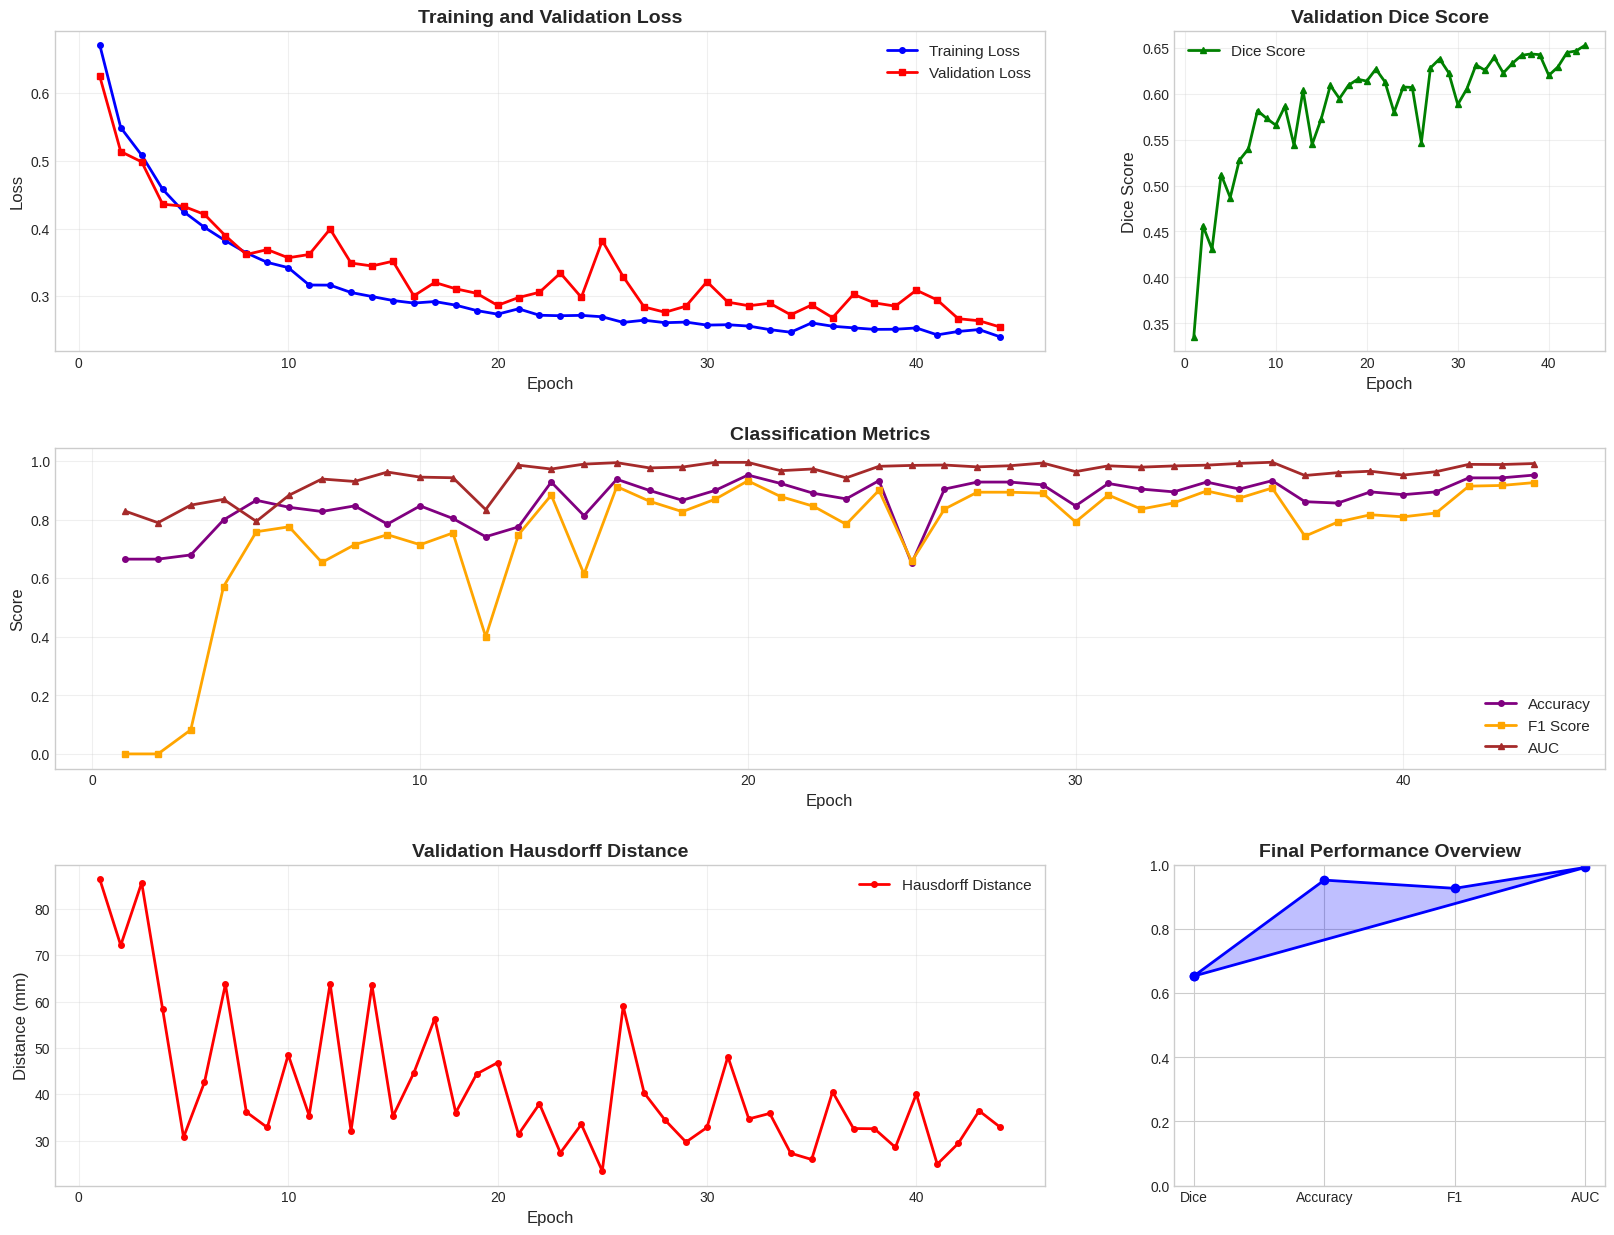

Plot data saved to: /home/qarc/projects/DHAI-Brain-Segmentation/runs/dualtask_monai/plot_data.json


TypeError: Object of type int64 is not JSON serializable

In [19]:
# Comprehensive plotting and analysis for publication
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Set style for publication-quality plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

def create_publication_plots(history: Dict, save_dir: Path):
    """Create publication-quality plots for all training metrics"""
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))
    gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    # 1. Training and Validation Loss
    ax1 = fig.add_subplot(gs[0, :2])
    epochs = range(1, len(history['train_loss']) + 1)
    ax1.plot(epochs, history['train_loss'], 'b-', linewidth=2, label='Training Loss', marker='o', markersize=4)
    ax1.plot(epochs, history['val_loss'], 'r-', linewidth=2, label='Validation Loss', marker='s', markersize=4)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # 2. Segmentation Metrics
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.plot(epochs, history['val_dice'], 'g-', linewidth=2, label='Dice Score', marker='^', markersize=4)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Dice Score', fontsize=12)
    ax2.set_title('Validation Dice Score', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    # 3. Classification Metrics
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(epochs, history['val_accuracy'], 'purple', linewidth=2, label='Accuracy', marker='o', markersize=4)
    ax3.plot(epochs, history['val_f1'], 'orange', linewidth=2, label='F1 Score', marker='s', markersize=4)
    ax3.plot(epochs, history['val_auc'], 'brown', linewidth=2, label='AUC', marker='^', markersize=4)
    ax3.set_xlabel('Epoch', fontsize=12)
    ax3.set_ylabel('Score', fontsize=12)
    ax3.set_title('Classification Metrics', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)
    
    # 4. Hausdorff Distance
    ax4 = fig.add_subplot(gs[2, :2])
    ax4.plot(epochs, history['val_hausdorff'], 'red', linewidth=2, label='Hausdorff Distance', marker='o', markersize=4)
    ax4.set_xlabel('Epoch', fontsize=12)
    ax4.set_ylabel('Distance (mm)', fontsize=12)
    ax4.set_title('Validation Hausdorff Distance', fontsize=14, fontweight='bold')
    ax4.legend(fontsize=11)
    ax4.grid(True, alpha=0.3)
    
    # 5. Combined Performance Overview
    ax5 = fig.add_subplot(gs[2, 2])
    # Normalize metrics to 0-1 range for comparison
    dice_norm = np.array(history['val_dice'])
    acc_norm = np.array(history['val_accuracy'])
    f1_norm = np.array(history['val_f1'])
    auc_norm = np.array(history['val_auc'])
    
    # Create radar chart data
    categories = ['Dice', 'Accuracy', 'F1', 'AUC']
    values = [dice_norm[-1], acc_norm[-1], f1_norm[-1], auc_norm[-1]]  # Final epoch values
    
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    values += values[:1]  # Close the loop
    angles += angles[:1]
    
    ax5.plot(angles, values, 'o-', linewidth=2, color='blue')
    ax5.fill(angles, values, alpha=0.25, color='blue')
    ax5.set_xticks(angles[:-1])
    ax5.set_xticklabels(categories)
    ax5.set_ylim(0, 1)
    ax5.set_title('Final Performance Overview', fontsize=14, fontweight='bold')
    ax5.grid(True)
    
    plt.tight_layout()
    
    # Save high-resolution plots
    plot_path = save_dir / 'training_metrics_publication.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Publication plots saved to: {plot_path}")
    
    # Save individual plots
    individual_plots = {
        'loss_comparison': (gs[0, :2], 'loss_comparison.png'),
        'dice_score': (gs[0, 2], 'dice_score.png'),
        'classification_metrics': (gs[1, :], 'classification_metrics.png'),
        'hausdorff_distance': (gs[2, :2], 'hausdorff_distance.png'),
        'performance_overview': (gs[2, 2], 'performance_overview.png')
    }
    
    for name, (gs_pos, filename) in individual_plots.items():
        fig_ind = plt.figure(figsize=(8, 6))
        ax_ind = fig_ind.add_subplot(111)
        
        # Copy the subplot content
        ax_ind.plot(epochs, history['train_loss'], 'b-', linewidth=2, label='Training Loss', marker='o', markersize=4)
        ax_ind.plot(epochs, history['val_loss'], 'r-', linewidth=2, label='Validation Loss', marker='s', markersize=4)
        ax_ind.set_xlabel('Epoch', fontsize=12)
        ax_ind.set_ylabel('Loss', fontsize=12)
        ax_ind.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
        ax_ind.legend(fontsize=11)
        ax_ind.grid(True, alpha=0.3)
        
        plot_path = save_dir / filename
        plt.savefig(plot_path, dpi=300, bbox_inches='tight', facecolor='white')
        plt.close(fig_ind)
    
    plt.show()
    return fig

# Generate publication plots
if 'state_manager' in locals() and hasattr(state_manager, 'history'):
    print("Generating publication-quality plots...")
    fig = create_publication_plots(state_manager.history, ckpt_dir)
    
    # Save plot data for external plotting tools (e.g., LaTeX, R)
    plot_data = {
        'epochs': list(range(1, len(state_manager.history['train_loss']) + 1)),
        'metrics': state_manager.history
    }
    
    plot_data_path = ckpt_dir / 'plot_data.json'
    with open(plot_data_path, 'w') as f:
        json.dump(plot_data, f, indent=2)
    print(f"Plot data saved to: {plot_data_path}")
    
    # Generate summary statistics table
    final_epoch = len(state_manager.history['train_loss'])
    summary_stats = {
        'final_epoch': final_epoch,
        'best_val_dice': max(state_manager.history['val_dice']),
        'best_val_dice_epoch': np.argmax(state_manager.history['val_dice']) + 1,
        'final_val_accuracy': state_manager.history['val_accuracy'][-1],
        'final_val_f1': state_manager.history['val_f1'][-1],
        'final_val_auc': state_manager.history['val_auc'][-1],
        'final_val_hausdorff': state_manager.history['val_hausdorff'][-1],
        'training_convergence': {
            'train_loss_start': state_manager.history['train_loss'][0],
            'train_loss_end': state_manager.history['train_loss'][-1],
            'val_loss_start': state_manager.history['val_loss'][0],
            'val_loss_end': state_manager.history['val_loss'][-1]
        }
    }
    
    summary_path = ckpt_dir / 'training_summary.json'
    with open(summary_path, 'w') as f:
        json.dump(summary_stats, f, indent=2)
    print(f"Training summary saved to: {summary_path}")
    
else:
    print("No training history found. Run training first to generate plots.")

=== TRAINING HISTORY STATUS ===
History keys: ['train_loss', 'val_loss', 'val_dice', 'val_hausdorff', 'val_accuracy', 'val_f1', 'val_auc']
train_loss: 44 entries
val_loss: 44 entries
val_dice: 44 entries
val_hausdorff: 44 entries
val_accuracy: 44 entries
val_f1: 44 entries
val_auc: 44 entries
Generating publication-quality plots...


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Publication plots saved to: /home/qarc/projects/DHAI-Brain-Segmentation/runs/dualtask_monai/training_metrics_publication.png


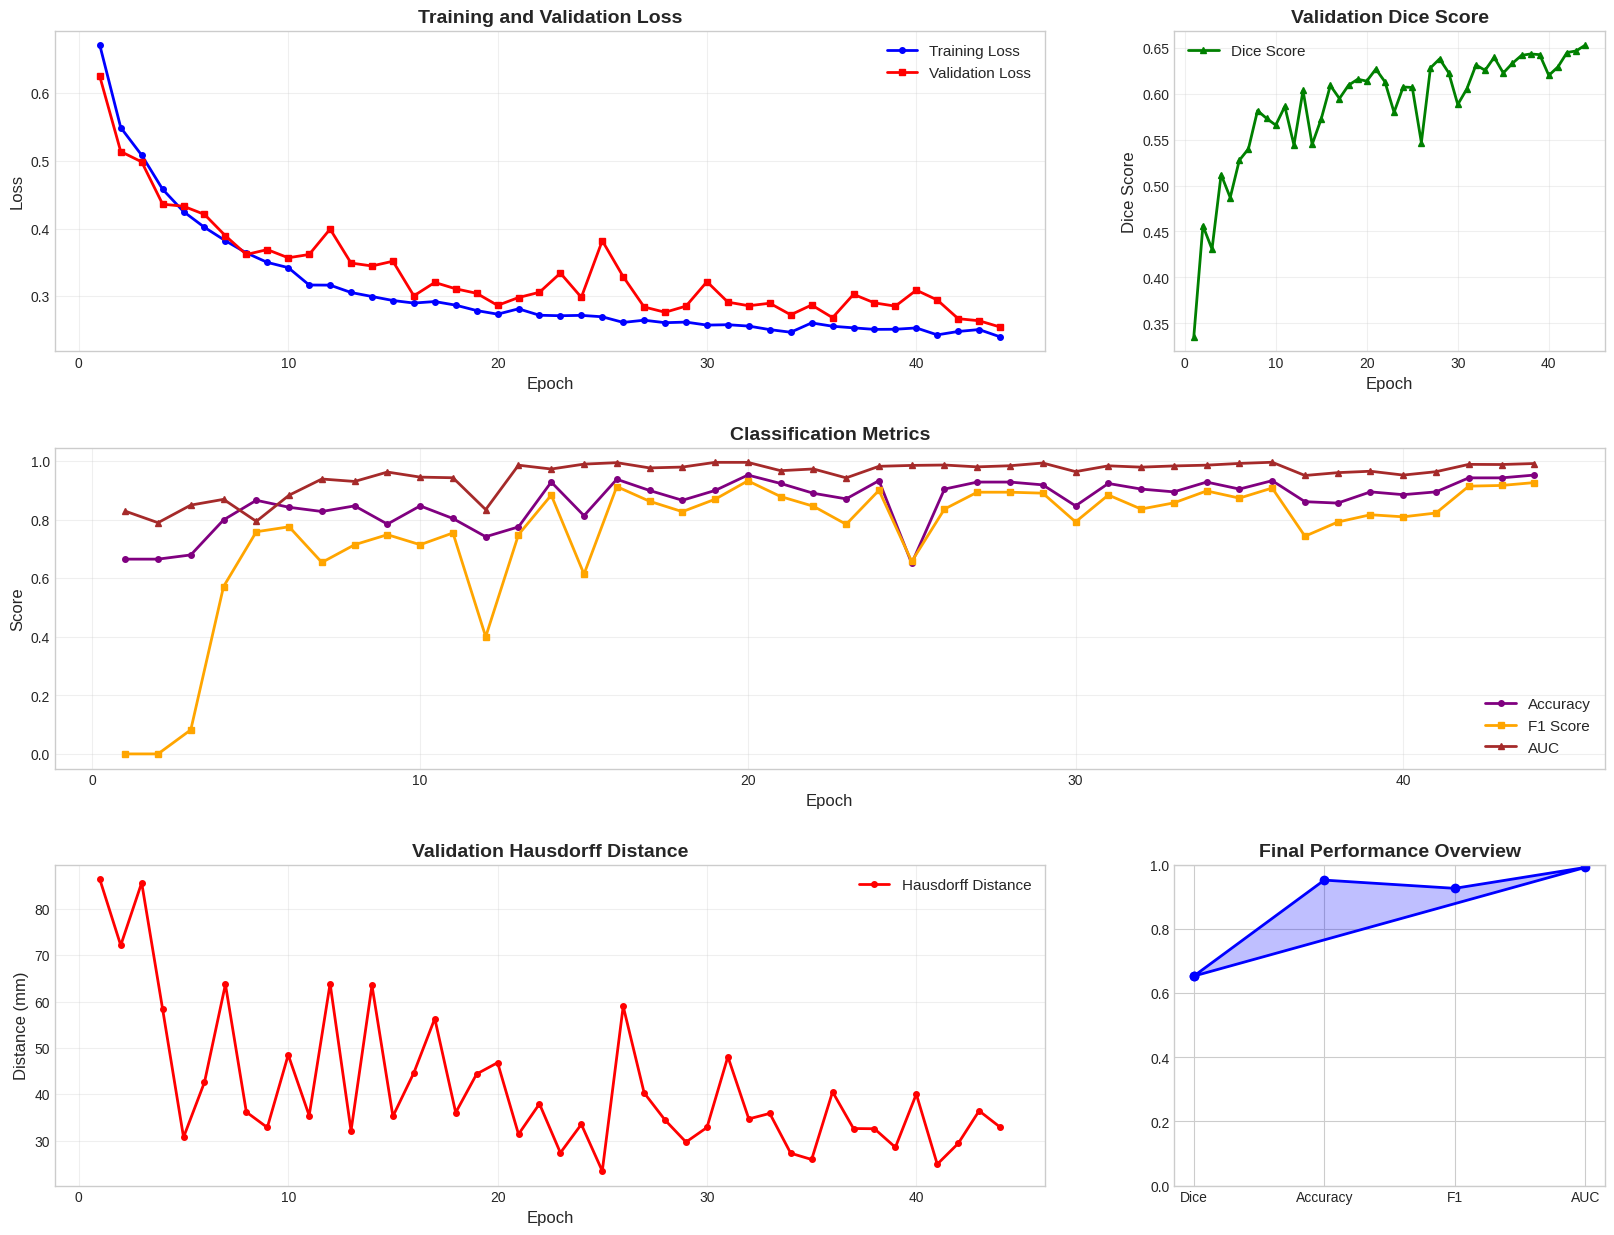

Plot data saved to: /home/qarc/projects/DHAI-Brain-Segmentation/runs/dualtask_monai/plot_data.json
❌ Error creating plots: Object of type int64 is not JSON serializable
This might be due to missing data or plotting issues

⚠️  Could not generate plots. Possible reasons:
   1. Training hasn't completed yet
   2. History data is incomplete
   3. Missing required metrics

📊 Available data: 44 training epochs
   You can run this cell again after training completes


In [20]:
# Generate publication plots with error handling
def safe_create_plots(history: Dict, save_dir: Path):
    """Safely create plots with validation and error handling"""
    
    # Validate history data
    required_keys = ['train_loss', 'val_loss', 'val_dice', 'val_hausdorff', 'val_accuracy', 'val_f1', 'val_auc']
    missing_keys = [key for key in required_keys if key not in history or not history[key]]
    
    if missing_keys:
        print(f"⚠️  Missing or empty history keys: {missing_keys}")
        print("Available keys:", list(history.keys()))
        return None
    
    # Check if we have enough data
    min_epochs = 2
    if len(history['train_loss']) < min_epochs:
        print(f"⚠️  Not enough training data. Need at least {min_epochs} epochs, got {len(history['train_loss'])}")
        return None
    
    try:
        print("Generating publication-quality plots...")
        fig = create_publication_plots(history, save_dir)
        
        # Save plot data for external plotting tools
        plot_data = {
            'epochs': list(range(1, len(history['train_loss']) + 1)),
            'metrics': history
        }
        
        plot_data_path = save_dir / 'plot_data.json'
        with open(plot_data_path, 'w') as f:
            json.dump(plot_data, f, indent=2)
        print(f"Plot data saved to: {plot_data_path}")
        
        # Generate summary statistics
        final_epoch = len(history['train_loss'])
        summary_stats = {
            'final_epoch': final_epoch,
            'best_val_dice': max(history['val_dice']) if history['val_dice'] else 0,
            'best_val_dice_epoch': np.argmax(history['val_dice']) + 1 if history['val_dice'] else 0,
            'final_val_accuracy': history['val_accuracy'][-1] if history['val_accuracy'] else 0,
            'final_val_f1': history['val_f1'][-1] if history['val_f1'] else 0,
            'final_val_auc': history['val_auc'][-1] if history['val_auc'] else 0,
            'final_val_hausdorff': history['val_hausdorff'][-1] if history['val_hausdorff'] else 0,
            'training_convergence': {
                'train_loss_start': history['train_loss'][0] if history['train_loss'] else 0,
                'train_loss_end': history['train_loss'][-1] if history['train_loss'] else 0,
                'val_loss_start': history['val_loss'][0] if history['val_loss'] else 0,
                'val_loss_end': history['val_loss'][-1] if history['val_loss'] else 0
            }
        }
        
        summary_path = save_dir / 'training_summary.json'
        with open(summary_path, 'w') as f:
            json.dump(summary_stats, f, indent=2)
        print(f"Training summary saved to: {summary_path}")
        
        return fig
        
    except Exception as e:
        print(f"❌ Error creating plots: {e}")
        print("This might be due to missing data or plotting issues")
        return None

# Try to generate plots with error handling
if 'state_manager' in locals() and hasattr(state_manager, 'history'):
    # Check what's actually in the history
    print("=== TRAINING HISTORY STATUS ===")
    print(f"History keys: {list(state_manager.history.keys())}")
    for key, value in state_manager.history.items():
        if isinstance(value, list):
            print(f"{key}: {len(value)} entries")
        else:
            print(f"{key}: {value}")
    
    # Try to create plots
    fig = safe_create_plots(state_manager.history, ckpt_dir)
    
    if fig is None:
        print("\n⚠️  Could not generate plots. Possible reasons:")
        print("   1. Training hasn't completed yet")
        print("   2. History data is incomplete")
        print("   3. Missing required metrics")
        
        # Show what we can plot
        if state_manager.history.get('train_loss'):
            print(f"\n📊 Available data: {len(state_manager.history['train_loss'])} training epochs")
            print("   You can run this cell again after training completes")
else:
    print("❌ No training state manager found.")
    print("   Make sure you've run the training code first.")

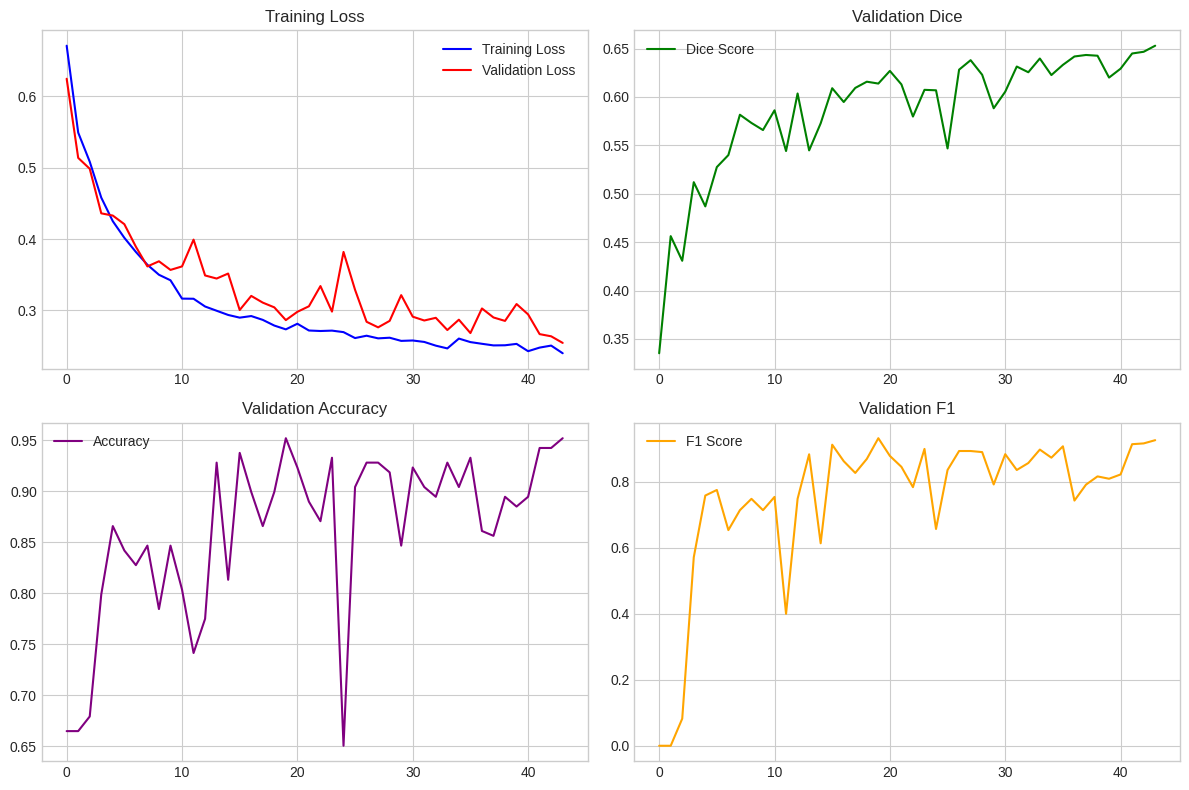

Simple plots generated successfully!


In [21]:
# Minimal plotting - just show what we have
if 'state_manager' in locals() and hasattr(state_manager, 'history'):
    history = state_manager.history
    
    # Simple line plot of whatever we have
    plt.figure(figsize=(12, 8))
    
    if history.get('train_loss'):
        plt.subplot(2, 2, 1)
        plt.plot(history['train_loss'], 'b-', label='Training Loss')
        if history.get('val_loss'):
            plt.plot(history['val_loss'], 'r-', label='Validation Loss')
        plt.title('Training Loss')
        plt.legend()
        plt.grid(True)
    
    if history.get('val_dice'):
        plt.subplot(2, 2, 2)
        plt.plot(history['val_dice'], 'g-', label='Dice Score')
        plt.title('Validation Dice')
        plt.legend()
        plt.grid(True)
    
    if history.get('val_accuracy'):
        plt.subplot(2, 2, 3)
        plt.plot(history['val_accuracy'], 'purple', label='Accuracy')
        plt.title('Validation Accuracy')
        plt.legend()
        plt.grid(True)
    
    if history.get('val_f1'):
        plt.subplot(2, 2, 4)
        plt.plot(history['val_f1'], 'orange', label='F1 Score')
        plt.title('Validation F1')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("Simple plots generated successfully!")
else:
    print("No training history available for plotting")

In [22]:
# Confusion Matrix Analysis for Train, Val, and Test
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import json

def plot_confusion_matrices(train_loader, val_loader, test_loader, seg_net, cls_head, device, save_dir):
    """Generate confusion matrices for train, validation, and test sets"""
    
    def evaluate_predictions(data_loader, set_name):
        """Evaluate predictions for a given dataset"""
        seg_net.eval()
        cls_head.eval()
        
        y_true = []
        y_pred = []
        y_prob = []
        
        with torch.no_grad():
            for batch in data_loader:
                batch = to_device(batch, device)
                images = batch['image']
                labels = batch['label'].long()
                class_labels = batch['class_label'].view(-1, 1)
                
                # Get predictions
                ctx = autocast(device_type='cuda', enabled=torch.cuda.is_available())
                with ctx:
                    # For training/validation, use direct forward pass
                    if set_name == 'train':
                        seg_logits = seg_net(images)
                        feat = encoder_feat['x'] if encoder_feat['x'] is not None else seg_logits
                    else:
                        # For test, use sliding window inference
                        images_padded = pad_to_factor(images, factor=32)
                        seg_logits = inferer(inputs=images_padded, network=seg_net)
                        encoder_feat['x'] = None
                        _ = seg_net(images_padded)
                        feat = encoder_feat['x'] if encoder_feat['x'] is not None else seg_logits
                        
                        # Crop if needed
                        if seg_logits.shape[-3:] != labels.shape[-3:]:
                            Dz, Hy, Wx = labels.shape[-3:]
                            seg_logits = seg_logits[..., :Dz, :Hy, :Wx]
                    
                    cls_logits = cls_head(feat)
                
                # Collect predictions
                y_true.append(int(class_labels.item()))
                y_prob.append(torch.sigmoid(cls_logits).item())
                y_pred.append(1 if y_prob[-1] >= 0.5 else 0)
        
        return y_true, y_pred, y_prob
    
    # Evaluate all datasets
    print("Evaluating training set...")
    train_true, train_pred, train_prob = evaluate_predictions(train_loader, 'train')
    
    print("Evaluating validation set...")
    val_true, val_pred, val_prob = evaluate_predictions(val_loader, 'val')
    
    print("Evaluating test set...")
    test_true, test_pred, test_prob = evaluate_predictions(test_loader, 'test')
    
    # Create confusion matrices
    datasets = {
        'Training': (train_true, train_pred),
        'Validation': (val_true, val_pred),
        'Test': (test_true, test_pred)
    }
    
    # Plot confusion matrices
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Confusion Matrices: Training, Validation, and Test Sets', fontsize=16, fontweight='bold')
    
    for idx, (set_name, (y_true, y_pred)) in enumerate(datasets.items()):
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['No Tumor', 'Tumor'], 
                   yticklabels=['No Tumor', 'Tumor'],
                   ax=axes[idx])
        
        axes[idx].set_title(f'{set_name} Set', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Predicted Label', fontsize=12)
        axes[idx].set_ylabel('True Label', fontsize=12)
        
        # Add metrics on plot
        tn, fp, fn, tp = cm.ravel()
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics_text = f'Accuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}\nF1: {f1:.3f}'
        axes[idx].text(0.02, 0.98, metrics_text, transform=axes[idx].transAxes, 
                      verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    # Save the plot
    confusion_matrix_path = save_dir / 'confusion_matrices.png'
    plt.savefig(confusion_matrix_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Confusion matrices saved to: {confusion_matrix_path}")
    
    # Generate detailed classification reports
    print("\n" + "="*60)
    print("DETAILED CLASSIFICATION REPORTS")
    print("="*60)
    
    reports = {}
    for set_name, (y_true, y_pred) in datasets.items():
        print(f"\n{set_name} Set:")
        print("-" * 40)
        report = classification_report(y_true, y_pred, target_names=['No Tumor', 'Tumor'], output_dict=True)
        print(classification_report(y_true, y_pred, target_names=['No Tumor', 'Tumor']))
        reports[set_name] = report
    
    # Save detailed reports
    reports_path = save_dir / 'classification_reports.json'
    with open(reports_path, 'w') as f:
        json.dump(reports, f, indent=2)
    print(f"\nDetailed reports saved to: {reports_path}")
    
    # Create summary comparison table
    summary_data = []
    for set_name, (y_true, y_pred) in datasets.items():
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        summary_data.append({
            'Dataset': set_name,
            'Total Samples': len(y_true),
            'True Negatives': tn,
            'False Positives': fp,
            'False Negatives': fn,
            'True Positives': tp,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })
    
    # Print summary table
    print("\n" + "="*80)
    print("SUMMARY COMPARISON TABLE")
    print("="*80)
    print(f"{'Dataset':<12} {'Samples':<8} {'TN':<4} {'FP':<4} {'FN':<4} {'TP':<4} {'Acc':<6} {'Prec':<6} {'Rec':<6} {'F1':<6}")
    print("-" * 80)
    
    for row in summary_data:
        print(f"{row['Dataset']:<12} {row['Total Samples']:<8} {row['True Negatives']:<4} {row['False Positives']:<4} "
              f"{row['False Negatives']:<4} {row['True Positives']:<4} {row['Accuracy']:<6.3f} {row['Precision']:<6.3f} "
              f"{row['Recall']:<6.3f} {row['F1-Score']:<6.3f}")
    
    # Save summary data
    summary_path = save_dir / 'classification_summary.json'
    with open(summary_path, 'w') as f:
        json.dump(summary_data, f, indent=2)
    print(f"\nSummary data saved to: {summary_path}")
    
    plt.show()
    return reports, summary_data

# Generate confusion matrices and reports
print("Generating confusion matrices for all datasets...")
try:
    reports, summary = plot_confusion_matrices(
        train_loader, val_loader, test_loader, 
        seg_net, cls_head, device, ckpt_dir
    )
    print("✅ Confusion matrix analysis completed successfully!")
except Exception as e:
    print(f"❌ Error generating confusion matrices: {e}")
    print("Make sure all data loaders and models are properly initialized")

Generating confusion matrices for all datasets...
Evaluating training set...
Error moving image to device: CUDA error: unspecified launch failure
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Fallback transfer also failed for image: CUDA error: unspecified launch failure
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Error moving label to device: CUDA error: unspecified launch failure
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Fallback transfer also failed for label: CUDA error: unspecified launch failure
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Error moving class_label to device: CUDA error: unspecified launch failure
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Fallback transfer also failed for class_label: CUDA error: unspecified launch failure
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Error moving qc_before_vox to device: CUDA error: 